Deep Graph Library (DGL)
=====================

DGL is designed to bring machine learning closer to graph-structured data. Specifically DGL enables trouble-free implementation of graph neural network (GNN) model family. Unlike PyTorch or TensorFlow, DGL provides friendly APIs to perform the fundamental operations in GNNs such as message passing and reduction. Through DGL, we hope to benefit both researchers trying out new ideas and engineers in production.

In this tutorial, we demonstrate the basics of DGL including:
- How to create a graph?
- How to manipulate node/edge features on a graph?
- How to convert a graph to/from other formats?

Although this tutorial uses [PyTorch](https://pytorch.org) as backend for tensor-related computations (thus some familiarity with PyTorch is preferred), DGL is designed to be platform-agnostic and can be seamlessly integrated into other frameworks like [MXNet](https://mxnet.apache.org/) and [TensorFlow](https://www.tensorflow.org/), and we are actively working on this.

In [9]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We start by creating the well-known *"Zachary's karate club"* social network. The network captures 34 members of a karate club, documenting pairwise links between members who interacted outside the club. The club later splits into two communities led by the instructor (node 0) and club president (node 33). You could read more about the story in the [wiki page](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) A visualization of the network and the community is as follows:

![karate](https://www.dropbox.com/s/uqzor4lqsmbnz8k/karate1.jpg?dl=1)

Creating a graph
-----------------------------------

Let's see how we can create such a graph in DGL. We start with importing `dgl` and other relevant packages.

In [10]:
import dgl

We first create an empty `DGLGraph`. In DGL, nodes are consecutive integers start from 0. The following codes add all the club members into this graph (34 nodes).

In [16]:
G = dgl.DGLGraph()
G.add_nodes(34)
print('Number of nodes:', G.number_of_nodes())

Number of nodes: 34


The Karate Club network contains 78 edges:
```
[1 0]
[2 0] [2 1]
[3 0] [3 1] [3 2]
[4 0]
[5 0]
[6 0] [6 4] [6 5]
[7 0] [7 1] [7 2] [7 3]
[8 0] [8 2]
[9 2]
[10 0] [10 4] [10 5]
[11 0]
[12 0] [12 3]
[13 0] [13 1] [13 2] [13 3]
[16 5] [16 6]
[17 0] [17 1]
[19 0] [19 1]
[21 0] [21 1]
[25 23] [25 24]
[27 2] [27 23] [27 24]
[28 2]
[29 23] [29 26]
[30 1] [30 8]
[31 0] [31 24] [31 25] [31 28]
[32 2] [32 8] [32 14] [32 15] [32 18] [32 20] [32 22] [32 23] [32 29] [32 30] [32 31]
[33 8] [33 9] [33 13] [33 14] [33 15] [33 18] [33 19] [33 20] [33 22] [33 23] [33 26] [33 27] [33 28] [33 29] [33 30] [33 31] [33 32]
```

In DGL, edges can be added by specifying the two endpoints.

In [88]:
G.add_edge(1, 0)
print('Now we have %d edges!' % G.number_of_edges())

Now we have 79 edges!


/Users/aviv/anaconda3/envs/cs236605-tutorials/lib/python3.7/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


To add multiple edges at once, use a list/tensor of nodes to specify the endpoints.

In [18]:
import torch

########
# NOTE: in DGL, edges are added by specifying a list of source nodes and a list of destination nodes,
# rather than a list of source-destination node pairs. This is different from other popular graph
# package such as networkx, python-igraph.

########
# NOTE: edges in DGLGraphs are all directional.

# add two edges 2->0 and 2->1 using list
G.add_edges([2, 2], [0, 1])

# add three edges 3->0, 3->1 and 3->2 using torch tensor
src = torch.tensor([3, 3, 3])
dst = torch.tensor([0, 1, 2])
G.add_edges(src, dst)

print('Now we have %d edges!' % G.number_of_edges())

Now we have 6 edges!


In [19]:
# add two edges 4->0, 5->0 using list
G.add_edges([4, 5], 0)

# add three edges 6->0 6->4 6->5 using torch tensor
G.add_edges(6, torch.tensor([0, 4, 5]))

print('Now we have %d edges!' % G.number_of_edges())

Now we have 11 edges!


If the edges share the same source or destination nodes, the list/tensor type can be replaced with a single integer.

In [20]:
# Exercise: please finish the karate club graph by adding the remaining edges. We have provided you all the
# remaining edge tuples in a list.

edge_list = [(7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4), (10, 5),
             (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2), (13, 3), (16, 5), (16, 6),
             (17, 0), (17, 1), (19, 0), (19, 1), (21, 0), (21, 1), (25, 23), (25, 24), (27, 2),
             (27, 23), (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8), (31, 0), (31, 24),
             (31, 25), (31, 28), (32, 2), (32, 8), (32, 14), (32, 15), (32, 18), (32, 20), (32, 22),
             (32, 23), (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13), (33, 14), (33, 15),
             (33, 18), (33, 19), (33, 20), (33, 22), (33, 23), (33, 26), (33, 27), (33, 28),
             (33, 29), (33, 30), (33, 31), (33, 32)]

# >>> YOUR CODE STARTS
src, dst = zip(*edge_list)
G.add_edges(src, dst)
# <<< YOUR CODE ENDS

# We should have 78 edges now!
print('Now we have %d edges!' % G.number_of_edges())

Now we have 78 edges!


In [23]:
G.adjacency_matrix()

tensor(indices=tensor([[ 0,  0,  1,  0,  1,  2,  0,  0,  0,  4,  5,  0,  1,  2,
                         3,  0,  2,  2,  0,  4,  5,  0,  0,  3,  0,  1,  2,  3,
                         5,  6,  0,  1,  0,  1,  0,  1, 23, 24,  2, 23, 24,  2,
                        23, 26,  1,  8,  0, 24, 25, 28,  2,  8, 14, 15, 18, 20,
                        22, 23, 29, 30, 31,  8,  9, 13, 14, 15, 18, 19, 20, 22,
                        23, 26, 27, 28, 29, 30, 31, 32],
                       [ 1,  2,  2,  3,  3,  3,  4,  5,  6,  6,  6,  7,  7,  7,
                         7,  8,  8,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13,
                        16, 16, 17, 17, 19, 19, 21, 21, 25, 25, 27, 27, 27, 28,
                        29, 29, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32,
                        32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33,
                        33, 33, 33, 33, 33, 33, 33, 33]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
      

In [40]:
W=G.adjacency_matrix()

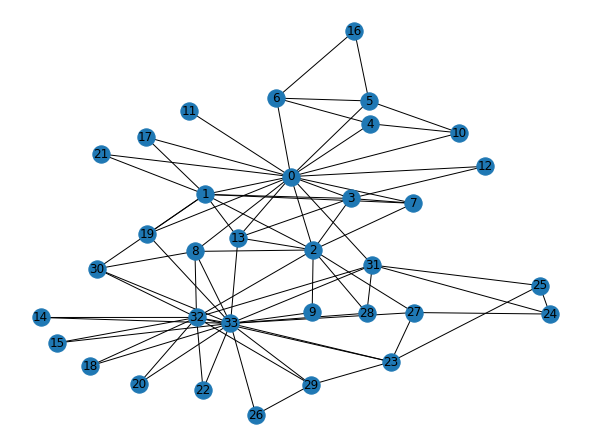

In [51]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
nx.draw(nx_G, pos=nx.kamada_kawai_layout(nx_G), with_labels=True,)

Manipulating node/edge features
---------------------------------------------------------

Nodes and edges in `DGLGraph` can have **features** tensors. Features of multiple nodes/edges are batched on the first dimension. Let's start by assigning a random feature vector of length 5 to all nodes.

In [41]:
G.ndata['feat'] = torch.randn((34, 5))

In [68]:
G.nodes[0,1,33].data['feat']

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.9895,  0.9376,  1.0680,  0.3748,  0.2200],
        [-0.6717,  0.1412, -1.3240, -0.7888,  0.2109]])

Now each node has a feature vector `'feat'` that has 5 elements. Note since there are 34 nodes in this graph, the first dimension must be of size 34, so that each row corresponds to the feature vector of each node. Error will be raised if the dimension mismatches:

In [63]:
# This will raise error!!
# G.ndata['wrong_feat'] = torch.randn((35, 5))

The `G.ndata` is a dictionary-like structure, so it is compatible with any operation on dictionary.

In [69]:
# Use `dict.update` to add new features (vector of length 3)
G.ndata.update({'another_feat' : torch.randn((34, 3))})

# Print the feature dictionary
print(G.ndata)

# Delete the new feature using `dict.pop`
G.ndata.pop('another_feat')

{'feat': tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.9895,  0.9376,  1.0680,  0.3748,  0.2200],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [-0.6133,  0.2241, -1.0141, -0.7779,  0.5753],
        [-0.0921, -1.5282,  1.6242,  0.4268, -0.9748],
        [-0.3359, -0.4139, -1.4211,  1.2544, -1.5662],
        [ 0.4692,  0.5297, -1.0092, -0.7201, -0.6241],
        [-0.5513, -0.8924, -0.8459, -0.2638,  0.9673],
        [-1.6537, -0.3196, -0.4324, -1.3940, -0.1553],
        [ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
        [ 0.1023,  0.9373, -0.5764, -0.9568,  0.1727],
        [-1.2406,  1.7744, -0.2573, -2.1166,  0.6259],
        [-0.2320,  1.9722,  2.0114,  0.0378,  2.3914],
        [ 0.7096, -0.9700,  2.1545,  0.1814, -2.1297],
        [ 0.9907, -0.2099, -1.3293,  1.0322, -0.9214],
 

tensor([[ 0.1890, -0.8864,  0.2646],
        [ 0.3114,  0.7353, -0.6278],
        [ 0.0339, -0.1153,  0.3933],
        [ 0.2902,  0.9656, -0.0992],
        [ 0.0464,  1.8307,  0.3005],
        [ 0.3222, -0.7052,  0.2493],
        [ 0.1455, -0.6092, -0.1262],
        [-1.9614, -0.6375, -0.3628],
        [-1.5704, -1.3995,  0.5091],
        [ 2.1689,  0.3686, -0.5765],
        [-0.8817, -1.2685,  0.0933],
        [ 0.1909, -0.5993, -0.9261],
        [-0.9904,  0.0497, -0.0996],
        [ 0.0613,  0.8107, -0.2348],
        [-0.0746,  0.7555, -0.9349],
        [-0.5944,  0.2998, -0.2195],
        [-0.7753, -0.1526,  0.7911],
        [-1.5888, -0.8618, -1.3420],
        [-0.2223, -1.1518,  2.2613],
        [-0.9318, -0.2146,  1.3076],
        [ 0.0390,  0.2558,  0.8859],
        [ 0.5414,  0.8244, -1.3000],
        [ 0.2173, -0.3713,  0.0214],
        [-1.7729,  0.3069, -1.0404],
        [ 0.9158, -0.2371, -1.2047],
        [-0.3673,  1.6750, -1.4940],
        [-0.7405, -0.3712, -0.6457],
 

Sometimes, you might want to update features of some but not all of the nodes. This can be done using the following syntax:

In [71]:
# Set node 0's feat to be all-zeros vector. Please be aware of the extra size 1 dimension here.
G.nodes[0].data['feat'] = torch.zeros((1, 5))

# Set node 2, 3's feat to be all-ones vector at once using list type.
G.nodes[[2, 3]].data['feat'] = torch.ones((2, 5))

# Set node 10, 11, 12's feat to be all-twos vector at once using tensor type.
to_change = torch.tensor([10, 11, 12])
G.nodes[to_change].data['feat'] = torch.ones((3, 5)) * 2

Similar to `G.ndata` and `G.nodes`, we have `G.edata` and `G.edges` to access and modify edge features:

In [72]:
G.nodes[10,11,12,13]

NodeSpace(data={'feat': tensor([[ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
        [ 0.1023,  0.9373, -0.5764, -0.9568,  0.1727]])})

In [75]:
G.ndata['feat'][10:14]

tensor([[ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000,  2.0000],
        [ 0.1023,  0.9373, -0.5764, -0.9568,  0.1727]])

In [79]:
G.predecessors(0)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31])

In [82]:
# The broness edge feature is just a scalar.
G.edata['broness'] = torch.ones((G.number_of_edges(),))

# The instructor (node 0) is a tough guy, so his friends are a little bit scared of him.
G.edges[G.predecessors(0), 0].data['broness'] *= 0.5

print(G.edata)

{'broness': tensor([0.5000, 0.5000, 1.0000, 0.5000, 1.0000, 1.0000, 0.5000, 0.5000, 0.5000,
        1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000,
        0.5000, 1.0000, 1.0000, 0.5000, 0.5000, 1.0000, 0.5000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 0.5000, 1.0000, 0.5000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])}


In [83]:
# Exercise: We know that measuring bro-ness cannot be accurate. Could you add some small random noise to it?
# Hint: Use `torch.randn` to add small permutation to it.
#
# >>> YOUR CODE STARTS
G.edata['broness'] += torch.randn_like(G.edata['broness']) * 0.1
# <<< YOUR CODE ENDS

# You should see some randomness here
print(G.edata['broness'])

tensor([0.3852, 0.7478, 0.9014, 0.5588, 1.0847, 0.9460, 0.5511, 0.7238, 0.3783,
        1.0942, 1.0946, 0.4362, 0.8990, 0.9718, 1.1088, 0.5358, 1.1570, 1.0278,
        0.5084, 0.9267, 0.9957, 0.4713, 0.6109, 1.0244, 0.7457, 0.9467, 0.9224,
        0.9229, 0.9093, 0.5949, 0.5690, 0.9444, 0.5820, 1.0656, 0.5305, 1.0358,
        0.9932, 0.7925, 0.9752, 1.0022, 1.0676, 0.9627, 1.0252, 1.1620, 0.9276,
        1.1479, 0.4970, 1.0432, 1.0796, 0.9393, 0.9869, 1.1091, 0.7988, 1.0636,
        1.0012, 1.1295, 1.0009, 0.9947, 1.1005, 1.1078, 0.9682, 1.0190, 0.9352,
        0.9443, 1.0668, 0.7707, 1.0037, 0.9323, 1.0279, 1.0438, 0.9195, 1.0279,
        1.0077, 1.0627, 0.8194, 1.0017, 0.8945, 0.9206])


Converting to/from networkx graph and sparse matrix
-----------------------------------------------------------------

[Networkx](https://networkx.github.io/documentation/stable/) is a classical and popular python graph library. It provides many good utilities to analyze and visualize a graph. `DGLGraph` can be easily converted to/from `networkx` graph very easily:

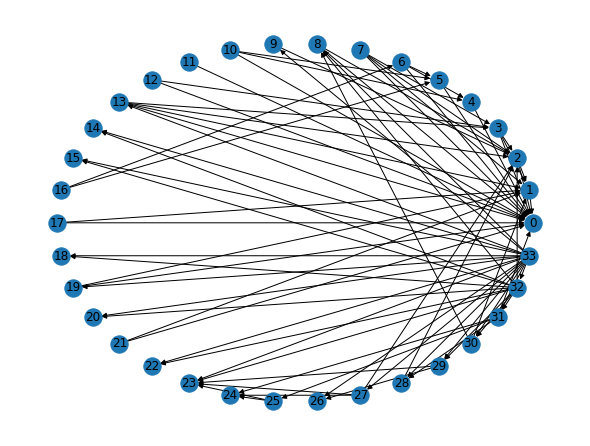

In [84]:
import networkx as nx

nx_G = G.to_networkx()
pos = nx.circular_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)

Constructing a DGLGraph from networkx is straight-forward. In fact, DGL borrows many of the networkx utilities to create graph from different format:

In [85]:
# from networkx graph
G_from_nx = dgl.DGLGraph(nx_G)  # this gives you the same karate club network

# from edge list
G_from_elist = dgl.DGLGraph([(0,1), (1,2), (2,3)])  # this gives you a chain graph

# from scipy sparse matrix
import scipy.sparse as sp
A = sp.eye(5, 5, 1)
G_from_sp = dgl.DGLGraph(A)  # this also gives you a chain of 5 nodes

In [94]:
W = G.adjacency_matrix().to_dense()
W

tensor([[0., 2., 1.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [92]:
torch.sum(W,dim=1)

tensor([17.,  8.,  8.,  3.,  2.,  3.,  1.,  0.,  3.,  1.,  0.,  0.,  0.,  1.,
         2.,  2.,  0.,  0.,  2.,  1.,  2.,  0.,  2.,  5.,  3.,  1.,  2.,  1.,
         2.,  2.,  2.,  2.,  1.,  0.])